In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# Load and pick Datas

In [2]:
# 读取训练集和测试集为 DataFrame
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


# Filling up missing values

In [3]:
def conbine_train_test_data():
    train_data2 = train_data.drop('SalePrice', axis=1)
    return pd.concat([train_data2, test_data])

conbined_data = conbine_train_test_data()
conbined_data.shape

(2919, 80)

In [4]:
# 存在缺失数据的列名
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# 每列包含多少缺失数据
conbined_data[has_null_columns].isnull().sum()

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

## Data Cleaning Plan
* `LotFrontage`: Linear feet of street connected to property. Impute mean, or maybe see if there's a correlation with `LotArea` (like square root?).

* `Alley`: Type of alley access to property -> Many missing values, I would presume that these properties just don't have an alley access.

* `MasVnrType/MasVnrArea` -> both have 8 values missing, I presume they are the same ones. Either set as "None"/0 or use most frequent value/median.

* `Bsmt... Variables`: A  number of variables in connection with the basement. About the same number of missing values. However, there are two basement-related variables without missing values "BsmtFinSF1" and "BsmtFinSF2" - look at those and then decide what to do with the missing values.

* `Electrical`: Just one missing value - here just impute most frequent one.

* `FireplaceQu`: I assume the properties with missing values just don't have a fireplace. There's also the variable Fireplaces (without missing values) - check this and then decide.

* `Garage ... Variables`: 81 missing in these columns. However, there are some Garage-related variables without missing values: GarageCars, GarageArea - check these and then decide.

* `PoolQC` - probably no pool - but check against PoolArea (which has no missing values).

* `Fence`: Many missing values - probably no fence, just impute 'None'

* `MiscFeature`: Assuming none - probably no special features, just impute 'None'

In [5]:
def fill_missing_conbined_data(column, value):
    conbined_data.loc[conbined_data[column].isnull(),column] = value

** LotFrontage/LotArea **

对于缺失的 LotFrontage，一般采用平均值进行填充，但考虑到可能与 LotArea 存在关系。

In [6]:
# Compute pairwise correlation of columns, excluding NA/null values
conbined_data['LotFrontage'].corr(conbined_data['LotArea'])

0.48989557038716691

LotArea: Lot size in square feet。LotArea 平方英尺为单位。考虑单位同一将 LotArea 进行 `sqrt()`

In [7]:
conbined_data['SqrtLotArea'] = np.sqrt(conbined_data['LotArea'])
conbined_data['LotFrontage'].corr(conbined_data['SqrtLotArea'])

0.64765803986178294

相关系数为 0.64765803986178294，说明 LotFrontage 与 LotArea 之间存在一定的正相关。下面对LotFrontage 与 LotArea 进行拟合。 

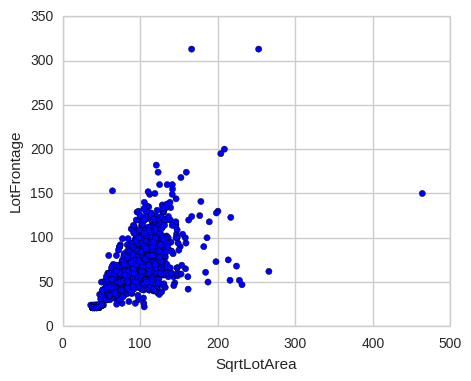

In [8]:
# 绘制 LotFrontage 与 LotArea 原始数据
lot_datas = conbined_data[['LotFrontage','SqrtLotArea']].dropna()
plt.figure(figsize=(5,4))
plt.scatter(lot_datas['SqrtLotArea'], lot_datas['LotFrontage'])
plt.xlabel("SqrtLotArea") 
plt.ylabel("LotFrontage") 

In [9]:
from sklearn.linear_model import LinearRegression

# Create linear regression object
regr = LinearRegression()

In [10]:
lotFrontage = lot_datas.iloc[:,0].values
sqrtLotArea = lot_datas.iloc[:,1].values

length = lotFrontage.shape[0]
lotFrontage = lotFrontage.reshape(length, 1)
sqrtLotArea = sqrtLotArea.reshape(length, 1)

# Train the model using the training sets
regr.fit(sqrtLotArea, lotFrontage)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
# The coefficients
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([[ 0.6430147]]))


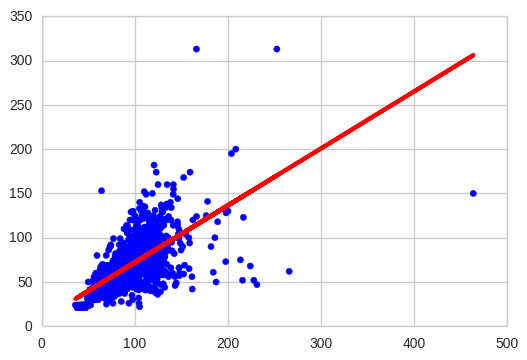

In [12]:
plt.scatter(sqrtLotArea, lotFrontage,  color='blue')
plt.plot(sqrtLotArea, regr.predict(sqrtLotArea), color='red',
         linewidth=3)

In [13]:
def fill_missing_lotfrontage(sqrt_lotarea):
    """
    填充缺失的 LotFrontage 数据
    """
    return 0.6430147 * sqrt_lotarea

column = conbined_data['LotFrontage'].isnull()
conbined_data['LotFrontage'][column] = conbined_data['SqrtLotArea'][column].map(fill_missing_lotfrontage)

In [14]:
conbined_data[conbined_data['LotFrontage'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SqrtLotArea


In [15]:
conbined_data.drop('SqrtLotArea', axis=1, inplace=True)
conbined_data.shape

(2919, 80)

** Alley **

In [16]:
conbined_data.shape, conbined_data[conbined_data['Alley'].isnull()].shape

((2919, 80), (2721, 80))

2919 条数据缺失 2721 条，缺失数据过多(93.2%),将缺失数据填充为 NA（NA->No alley access）。

In [17]:
fill_missing_conbined_data('Alley', 'NA')
conbined_data[conbined_data['Alley'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


** MasVnrType / MasVnrArea **

方形单板砌体类型/面积，将缺失数据填充为出现次数最多的类型

In [18]:
conbined_data['MasVnrType'].fillna('None', inplace=True)
conbined_data['MasVnrArea'].fillna(0, inplace=True)

In [19]:
conbined_data['MasVnrType'].isnull().sum(), conbined_data['MasVnrArea'].isnull().sum()

(0, 0)

** BsmtQual / BsmtCond / BsmtExposure / BsmtFinType1 / BsmtFinType2 **

缺失 37 / 38 条数据。

In [20]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

In [21]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Basement
for column in basement_cols:
    if 'FinSF'not in column:
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')

In [22]:
# 对于数值型的 BsmtFinSF1 和 BsmtFinSF2
fill_missing_conbined_data('BsmtFinSF1', 0)
fill_missing_conbined_data('BsmtFinSF2', 0)

In [23]:
conbined_data[basement_cols].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtFinSF1      0
BsmtFinSF2      0
dtype: int64

** Electrical **

缺失一条数据,填充为出现次数最多的。

In [24]:
fill_missing_conbined_data('Electrical', conbined_data['Electrical'].max())

** FireplaceQu **

缺失 1420 条数据
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality

所以 FireplaceQu 与 Fireplaces 有关系

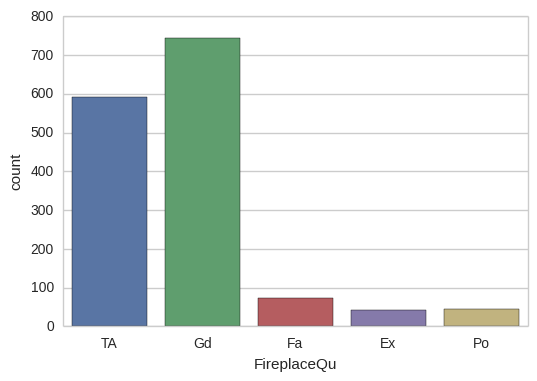

In [25]:
conbined_data['FireplaceQu'].value_counts()
conbined_data[['FireplaceQu', 'Fireplaces']].groupby(['FireplaceQu']).median()
sns.countplot(conbined_data['FireplaceQu'])

In [26]:
# 对于 Fireplaces 为 0 的，FireplaceQu 设置为 NA，表示 No Fireplace，此即缺失的 1420 条数据的情况
fill_missing_conbined_data('FireplaceQu', 'NA')

** PoolQC **

PoolQC 缺失 2909 条数据，是否与 PoolArea 有关。

In [27]:
fill_missing_conbined_data('PoolQC', 'NA')

** MiscFeature **

In [28]:
fill_missing_conbined_data('MiscFeature', 'NA')

** Fence **

In [29]:
fill_missing_conbined_data('Fence', 'NA')

** Garages **

In [30]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
conbined_data[garage_cols][conbined_data['GarageType'].isnull()==True].head(1)

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [31]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Garage
for column in garage_cols:
    if column != 'GarageCars' and column != 'GarageArea':
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')
    else:
        fill_missing_conbined_data(column, 0)

** MSZoning **

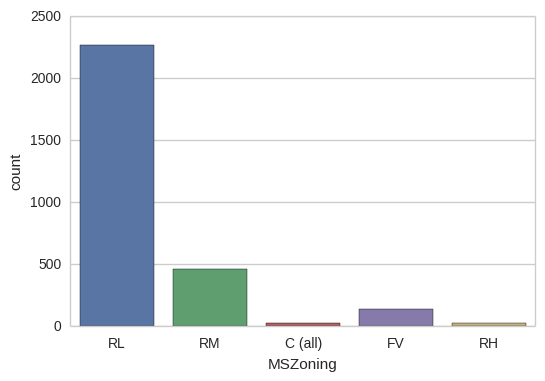

In [32]:
sns.countplot(conbined_data['MSZoning'])

In [33]:
conbined_data['MSZoning'].max()

'RM'

In [34]:
fill_missing_conbined_data('MSZoning', conbined_data['MSZoning'].max())

** Utilities **

In [35]:
fill_missing_conbined_data('Utilities', conbined_data['Utilities'].max())

** Exterior1st / Exterior2nd**

In [36]:
fill_missing_conbined_data('Exterior1st', conbined_data['Exterior1st'].max())

In [37]:
fill_missing_conbined_data('Exterior2nd', conbined_data['Exterior2nd'].max())

** BsmtUnfSF / TotalBsmtSF **

BsmtUnfSF: Unfinished square feet of basement area<br/>
BsmtFinSF2: Type 2 finished square feet<br/>
BsmtFinSF1: Type 1 finished square feet<br/>
TotalBsmtSF: Total square feet of basement area

测试发现：`TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF`

In [38]:
regr = LinearRegression()
bsmt_data = conbined_data[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']].dropna()

In [39]:
bsmt_x = bsmt_data.iloc[:,0:-1].values
bsmt_y = bsmt_data.iloc[:,-1].values

length = bsmt_x.shape[0]
bsmt_y = bsmt_y.reshape(length, 1)

# Train the model using the training sets
regr.fit(bsmt_x, bsmt_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
# The coefficients
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([[ 1.,  1.,  1.]]))


In [41]:
conbined_data[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']][conbined_data['BsmtUnfSF'].isnull()]

,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
660,NaN,0.0,0.0,NaN


In [42]:
# 可以发现，对于缺失的 TotalBsmtSF 和 BsmtUnfSF 填充为0
fill_missing_conbined_data('BsmtUnfSF', 0)
fill_missing_conbined_data('TotalBsmtSF', 0)

** BsmtFullBath / BsmtHalfBath **

BsmtFullBath: Basement full bathrooms<br/>
BsmtHalfBath: Basement half bathrooms<br/>
FullBath: Full bathrooms above grade<br/>
HalfBath: Half baths above grade

In [43]:
conbined_data['FullBath'].corr(conbined_data['BsmtFullBath'])

-0.018815125742370497

In [44]:
fill_missing_conbined_data('BsmtFullBath', 0)
fill_missing_conbined_data('BsmtHalfBath', 0)

** KitchenQual **

KitchenAbvGr: Kitchens above grade<br/>
KitchenQual: Kitchen quality

In [45]:
print conbined_data['KitchenQual'].max()
conbined_data[['KitchenAbvGr', 'KitchenQual']].groupby('KitchenQual').mean()

TA


,KitchenAbvGr
KitchenQual,
Ex,1.000000
Fa,1.128571
Gd,1.004344
TA,1.077748


In [46]:
# 差别并不大，填充为1
fill_missing_conbined_data('KitchenQual', conbined_data['KitchenQual'].max())

** SaleType / Functional **

In [47]:
fill_missing_conbined_data('SaleType', conbined_data['SaleType'].max())
fill_missing_conbined_data('Functional', conbined_data['Functional'].max())

完成了缺失数据的填充。

In [48]:
# 存在缺失数据的列名
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# 每列包含多少缺失数据
conbined_data[has_null_columns].isnull().sum()

Series([], dtype: float64)

# Feature Engineering

** 时间属性（YearBuilt、GarageYrBlt）**

In [49]:
built_year_data = conbined_data[['YearBuilt', 'GarageYrBlt']][conbined_data['GarageYrBlt'] != 'NA']

In [50]:
built_year_data['GarageYrBlt'] = built_year_data['GarageYrBlt'].map(lambda g : int(g))
built_year_data['GarageYrBlt'].corr(built_year_data['YearBuilt'])

0.83481237316310175

可以发现 YearBuilt、GarageYrBlt 之间存在很高的相关性。

In [51]:
built_year_data.head(1)

,YearBuilt,GarageYrBlt
0,2003,2003


('Coefficients: \n', array([[ 0.72418557]]))


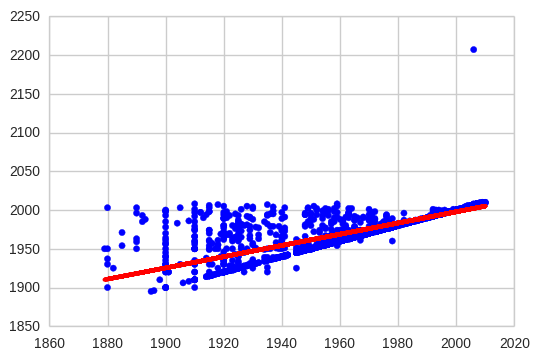

In [52]:
regr = LinearRegression()
garage_year = built_year_data.loc[:,'GarageYrBlt'].values
built_year = built_year_data.loc[:,'YearBuilt'].values

length = garage_year.shape[0]
garage_year = garage_year.reshape(length, 1)
built_year = built_year.reshape(length, 1)

# Train the model using the training sets
regr.fit(built_year, garage_year)
plt.scatter(built_year, garage_year,  color='blue')
plt.plot(built_year, regr.predict(built_year), color='red',
         linewidth=3)

# The coefficients
print('Coefficients: \n', regr.coef_)

In [53]:
# 对于 NA 的 GarageYrBlt，进行填充
conbined_data['GarageYrBlt'] = conbined_data.apply(lambda row : regr.predict(row['YearBuilt'])
                                                      if row['GarageYrBlt'] == 'NA' else row['GarageYrBlt'],
                                                       axis=1)

conbined_data['GarageYrBlt'] = conbined_data['GarageYrBlt'].map(lambda g : float(g))

In [54]:
conbined_data['GarageYrBlt'].head()

0    2003.0
1    1976.0
2    2001.0
3    1998.0
4    2000.0
Name: GarageYrBlt, dtype: float64

Feature Scale

In [55]:
from sklearn.preprocessing import MinMaxScaler
# remove warnings
import warnings
warnings.filterwarnings('ignore')

num_column_names = conbined_data.select_dtypes(exclude=['object']).columns.values
num_column_names = num_column_names[1:]
display(num_column_names)

MinMaxScaler().fit_transform(conbined_data[num_column_names])

display(conbined_data[num_column_names].head())
conbined_data[num_column_names] = conbined_data[num_column_names].apply(
                           lambda x: MinMaxScaler().fit_transform(x))

display(conbined_data[num_column_names].head())

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'], dtype=object)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.368280,0.000000,0.082210,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.309140,0.209270,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.408602,0.000000,0.056604,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0.431452,0.000000,0.047170,0.268775,0.0,0.0,0.0,0.0,0.090909,0.00
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0.561828,0.134831,0.113208,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50


** Dummy Encoding **

In [56]:
conbined_data = pd.get_dummies(conbined_data)

In [57]:
conbined_data.head(2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.1225,0.125089,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.0000,0.173281,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [58]:
train_length = train_data.shape[0]

train_X = conbined_data.iloc[:train_length, 1:]
train_Y = train_data['SalePrice']
test_X = conbined_data.iloc[train_length:, 1:]
test_Id = conbined_data.iloc[train_length:, 0]

print train_X.shape, train_Y.shape, test_X.shape, test_Id.shape

(1460, 302) (1460,) (1459, 302) (1459,)


In [59]:
del train_data
del test_data
del conbined_data

(array([   5.,   12.,   54.,  184.,  470.,  400.,  220.,   90.,   19.,    6.]),
 array([ 10.46027076,  10.76769112,  11.07511148,  11.38253184,
         11.6899522 ,  11.99737256,  12.30479292,  12.61221328,
         12.91963363,  13.22705399,  13.53447435]),
 <a list of 10 Patch objects>)

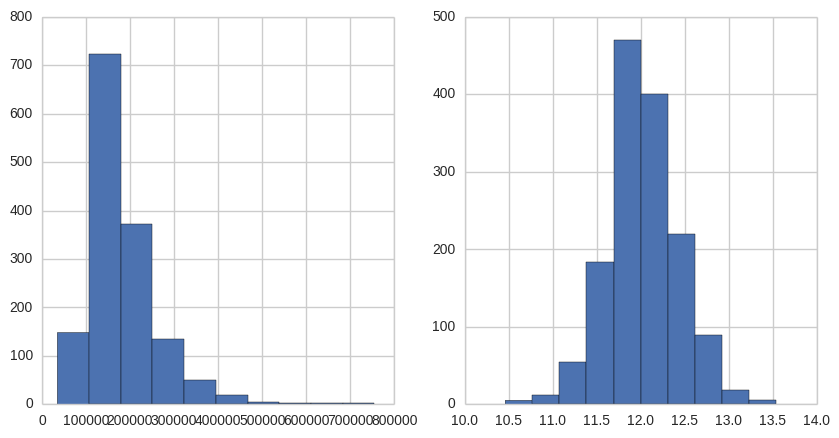

In [60]:
# 价格分布
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
axis1.hist(train_Y)
# Transform skewed numeric features using log(p+1) transformation making them more normal
train_Y = np.log1p(train_Y)
axis2.hist(train_Y)

In [61]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=0.01)
reg.fit(train_X, train_Y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

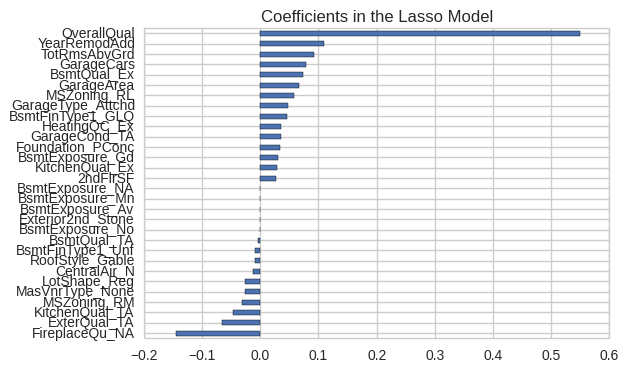

In [62]:
coef = pd.Series(reg.coef_, index = train_X.columns)

# plotting feature importances!
imp_coef = pd.concat([coef.sort_values().head(15),
                     coef.sort_values().tail(15)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# Modeling

In [63]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

# 随机森林模型的超参数选择
lasso_reg = Lasso()

lasso_parameter_grid = {
                 'alpha' : [1, 0.1, 0.01, 0.001],
                 'max_iter': [1000, 5000, 10000, 15000]
                 }

cross_validation = StratifiedKFold(train_Y, n_folds=5)

lasso_grid_search = GridSearchCV(lasso_reg,
                           param_grid=lasso_parameter_grid,
                           cv=cross_validation)

lasso_grid_search.fit(train_X, train_Y)

print('Best score: {}'.format(lasso_grid_search.best_score_))
print('Best parameters: {}'.format(lasso_grid_search.best_params_))

lasso_predictions = lasso_grid_search.predict(test_X).astype(float)
lasso_predictions = np.power(np.e, lasso_predictions) - 1

submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": lasso_predictions
    })

submission.to_csv("result/lasso_grid_search_predictions_2_6.csv", index=False)

print "lasso_grid_search Done."

Best score: 0.821010105287
Best parameters: {'alpha': 0.001, 'max_iter': 1000}
lasso_grid_search Done.
